## import required packages

In [1]:
#a super learner model for regression
from math import sqrt
from numpy import vstack
from numpy import asarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import array
import pygeostat as gs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


Populating the interactive namespace from numpy and matplotlib


C:\Users\gamze\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## simulate data

In [3]:
griddef = gs.GridDef(gridfl='griddef.txt')

In [4]:
sgsimpar = '''                  Parameters for SGSIM
                  ********************

START OF PARAMETERS:
cluster.dat                   -file with data
1  2  3  4  0  0              -columns for X,Y,Z,vr,wt,sec.var.
-1.0       1.0e21             -trimming limits
0                             -transform the data (0=no, 1=yes)
sgsim.trn                     -file for output trans table
0                             -consider ref. dist (0=no, 1=yes)
histsmth.out                  -file with ref. dist distribution
1  2                          -columns for vr and wt
0.0    15.0                   -zmin,zmax(tail extrapolation)
1       0.0                   -lower tail option, parameter
1      15.0                   -upper tail option, parameter
1                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output
sgsim.out                     -file for simulation output
1                             -number of realizations to generate
{grid}
69069                         -random number seed
0     8                       -min and max original data for sim
48                            -number of simulated nodes to use
1                             -assign data to nodes (0=no, 1=yes)
1     3                       -multiple grid search (0=no, 1=yes),num
0                             -maximum data per octant (0=not used)
250  250.0  150.0             -maximum search radii (hmax,hmin,vert)
 0.0   0.0   0.0              -angles for search ellipsoid
51    51    11                -size of covariance lookup table
0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC
../data/ydata.dat             -file with LVM, EXDR, or COLC variable
4                             -column for secondary variable
{varg}

'''

varg = ("1    0.01                       -nst, nugget effect\n\
         3    0.99    135   0.0   0.0     -it,cc,azm,dip,tilt (ang1,ang2,ang3)\n\
        250    250    150                -a_hmax, a_hmin, a_vert (ranges)")


sgsim= gs.Program(program='sgsim',parfile='sgsim.par')

sgsim.run(parstr=sgsimpar.format(varg = varg,
                                 grid = griddef))

sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef, readfl=True)

Calling:  ['sgsim', 'sgsim.par']

 SGSIM Version: 4.000

  data file = cluster.dat                             
  input columns =            1           2           3           4           0
           0
  trimming limits =   -1.000000      1.0000000E+21
  transformation flag =            0
  transformation file = sgsim.trn                               
  consider smoothed distribution (1=yes) =            0
  file with smoothed distribution = histsmth.out                            
  columns =            1           2
  data limits (tails) =   0.0000000E+00   15.00000    
  lower tail =            1  0.0000000E+00
  upper tail =            1   15.00000    
  debugging level =            1
  debugging file = sgsim.dbg                               
  output file sgsim.out                               
  number of realizations =            1
  X grid specification =           50   5.000000       10.00000    
  Y grid specification =           50   5.000000       10.00000    
  Z grid

In [5]:
addcoordpar = '''                  Parameters for ADDCOORD
                  ***********************

START OF PARAMETERS:
{datafl}                          -file with data
addcoord.out                      -file for output
1                                 -realization number
{grid}
3 3 6                             -decimals for x, y, z (-1=exclude)
'''
addcoord= gs.Program(program='addcoord',parfile='addcoord.par')

addcoord.run(parstr=addcoordpar.format(datafl=sgsimfl.flname,grid = griddef))

Calling:  ['addcoord', 'addcoord.par']

 ADDCOORD VERSION: 4.1.0

 Data File = sgsim.out                               
 Output File = addcoord.out                            
 Realization number =            1
 X grid size =           50   5.00000000000000        10.0000000000000     
 Y grid size =           50   5.00000000000000        10.0000000000000     
 Z grid size =           25   5.00000000000000        10.0000000000000     
 decimals =            3           3           6
 
 Format: (f07.03,x,f07.03,x,f10.06,x,a)      

 ADDCOORD: 4.1.0 Finished



In [6]:
datafl = gs.DataFile(flname = 'addcoord.out',x='X',y='Y',z='Z', griddef=griddef, readfl=True)

In [7]:
datafl['value'] = 0.0

In [8]:
gs.write_gslib(pd.DataFrame(datafl.data, dtype = np.float32),'dataflpd.out')
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)


In [9]:
def points_in_circle_np(radius, x0, y0):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1,10, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1,10, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y

In [10]:
for j in range(245,95,-5):
    print(j)
    q = []
    a = pd.DataFrame(list(points_in_circle_np(j,250,250)))-4
    for i in range(5,250,5):
        a['z'] = i
        q.append(a)
        if i != 245:
            a = a.drop(columns='z')
    circle = np.vstack(q)
    circlepd = pd.DataFrame(circle, columns=['X','Y','Z'])
    idx,ingrid = griddef.coord_to_index1d(x=circlepd['X'],y=circlepd['Y'],z=circlepd['Z'])
    test = pd.DataFrame(np.vstack((sgsimfl.data['X'][idx],sgsimfl.data['Y'][idx],sgsimfl.data['Z'][idx],sgsimfl.data['value'][idx])).T,columns=['X','Y','Z','value'])
    print(len(idx))
    for k in idx:
        sgsimfl.data['value'][k] = np.power(math.e,(-2.25*np.power((1.7-(j/100)),2))) - .15 + np.random.uniform(low=0.01, high=0.08, size=(1)) + np.power(math.e,(-2.25*np.power((1.25-(sgsimfl.data['Z'][k]/100)),2))) - .15 + np.random.uniform(low=0.01, high=0.08, size=(1))
        if j == 100:
            sgsimfl.data['value'][k] = 0     

245
92120
240
88494
235
84868
230
81585
225
77616
220
74333
215
71148
210
67669
205
64533
200
61593
195
58408
190
55321
185
52528
180
49735
175
46942
170
44198
165
41944
160
39249
155
36848
150
34545
145
32340
140
29939
135
27979
130
25921
125
24010
120
21903
115
20384
110
18571
105
16807
100
15386


In [11]:
gs.write_gslib(sgsimfl,'dataflpd.out')
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
# print(sgsimfl.data.describe())

In [12]:
sgsimfl.data.describe()

,X,Y,Z,value
count,62500.000000,62500.000000,62500.000000,62500.000000
mean,250.000000,250.000000,125.000000,0.603993
std,144.309851,144.309851,72.111602,0.566861
min,5.000000,5.000000,5.000000,0.000000
25%,125.000000,125.000000,65.000000,0.000000
50%,250.000000,250.000000,125.000000,0.595716
75%,375.000000,375.000000,185.000000,1.061254
max,495.000000,495.000000,245.000000,1.855008


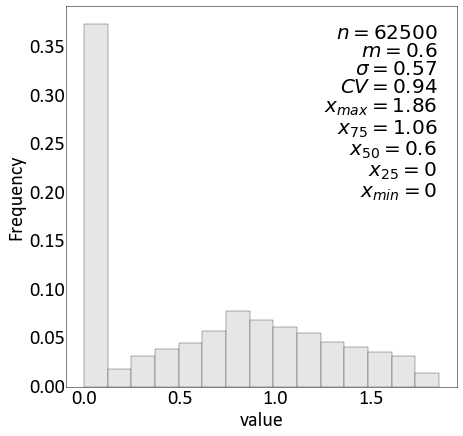

In [13]:
gs.set_style('pt20')
gs.histplt(sgsimfl.data,var = 'value', figsize = (7,7))
plt.savefig('./Figures/Simulated Data Hist.png',bbox_inches = 'tight', dpi = 150)

In [14]:
from scipy.stats import kurtosis, skew
skew(sgsimfl.data['value'])

# If skewness is less than -1 or greater than 1, the distribution is highly skewed.
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

0.3491288997631316

## sampling data

In [15]:
gsamplepar = '''       Parameters for gsample V2.000
     *********************************
       
START OF PARAMETERS:
1                            - Number of files to sample
{datafl}                     - File with first grid
1  {varcol1}                 - Number of variables and columns
1                            - Realization to sample
{griddef}
0                            - Sampling spacing option (0=regular, 1=random)
80  80                       - If 0, spacing in X, Y
45  45                       - If 0, collar of the first sample, X and Y (inside sampling grid)
80  69069                    - If 1, number of drill holes and seed number
0  90                        - Azimuth and dip
10                           - Sample spacing downhole
1                            - Starting drill hole ID for new drills
2                            - Number of decimal places (coordinates precision, up to 6)
5   495                      - Sampling grid: xmin, xmax
5   495                      -                ymin, ymax
5   245                      -                zmin, zmax
dhs.out                      - Output file with new drill holes
0                            - Output keyout file? (0=no, 1=yes)
0                            - If keyout (0=input grid inside sampling grid, 1=input blocks with assays)
keyout.out                   - Keyout file
------------------------------------------------
 -- OPTIONAL Extra Options for random drill sampling (sampling option 1) 
      NOTE: if extra option is used sampling will only occure in middle of blocks 
0                            - Use Extra Options (0 = NO, 1 = YES)
15  15                       - Minimum spacing in x and y direction - Note: dont use 0
------------------------------------------------
NOTE: using the minimum drill spacing could cause some issues
      with not drilling the number of drill holes that you
      really want to drill. So keep the minimum spacing low
Useing the extra option will force drilling to center of block
   and will only allow 1 drillhole per block - even if the
   minimum spacing is a lot smaller than a block size
'''
# gsample= gs.Program(program='gsample',parfile='gsample.par')

# gsample.run(parstr=gsamplepar.format(datafl=sgsimfl.flname,
#                                      varcol1=sgsimfl.gscol('value'),
#                                      griddef=griddef
#                                       ))

In [16]:
# sample data
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True) 


In [17]:
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl['Z'] = datasamplefl['Z']

In [18]:
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()

,X,Y,Z,value
count,864.000000,864.000000,864.000000,864.000000
mean,245.000000,245.000000,130.000000,0.718265
std,136.705139,136.705139,69.261963,0.517947
min,45.000000,45.000000,15.000000,0.000000
25%,125.000000,125.000000,72.500000,0.242775
50%,245.000000,245.000000,130.000000,0.722150
75%,365.000000,365.000000,187.500000,1.126425
max,445.000000,445.000000,245.000000,1.818200


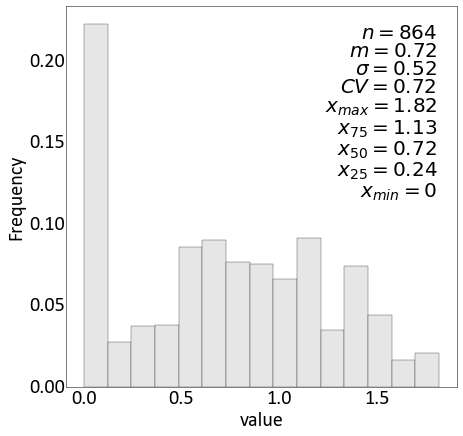

In [19]:
gs.set_style('pt20')
gs.histplt(datasamplefl,var = 'value', figsize = (7,7))
plt.savefig('./Figures/Sample Hist.png',bbox_inches = 'tight', dpi = 150)

## location maps

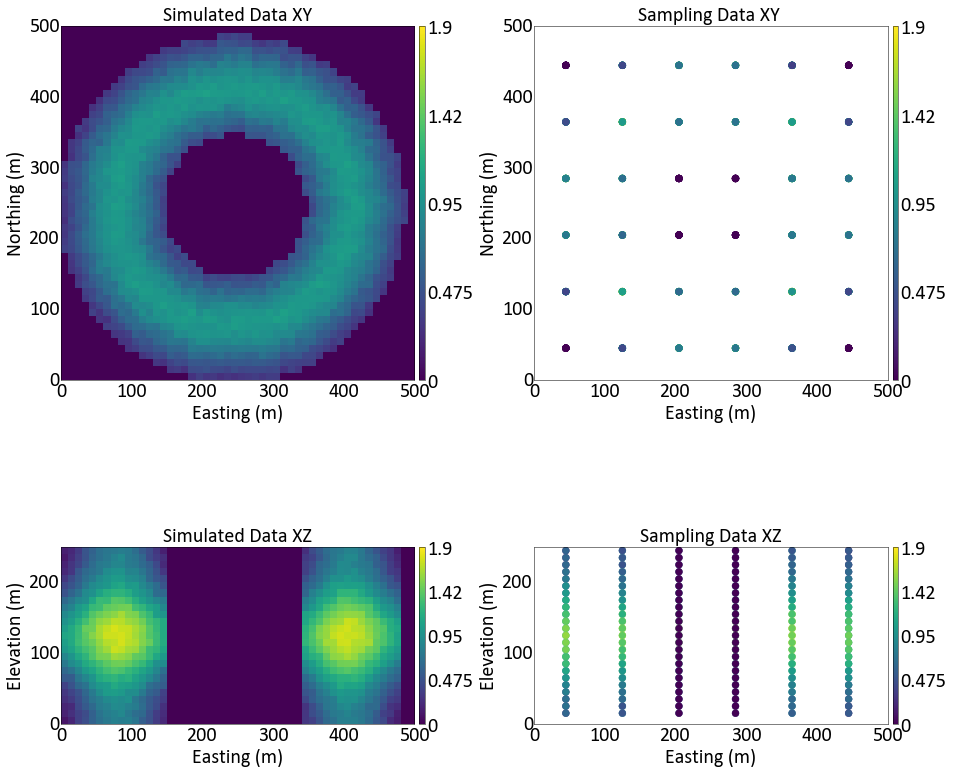

In [20]:
dataflpoints = dataflpoints[dataflpoints.data['Z'] != 0.1]
vlim = (0,1.9)
gs.set_style('pt20')
f, axes = plt.subplots(2, 2, figsize=(15, 15))
gs.locmap(dataflpoints,var = 'value',orient='xy', ax = axes[0,1],sliceno= 15,title = ('Sampling Data XY '),vlim=vlim)
gs.locmap(dataflpoints,var = 'value',orient='xz', ax = axes[1,1],sliceno= 15,title = ('Sampling Data XZ'),vlim=vlim)
gs.pixelplt(sgsimfl,var='value',sliceno= 20, ax = axes[0,0],title = ('Simulated Data XY'),vlim=vlim)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 20, ax = axes[1,0],title = ('Simulated Data XZ'),vlim=vlim)
plt.tight_layout()
plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.3, hspace = 0.001)
plt.savefig('./Figures/Data.png',vlim=vlim, bbox_inches = 'tight', dpi = 150)

In [21]:
# 3D output
outvtkfl = 'complex_out.vtk'
dataflpoints.writefile(flname=outvtkfl, fltype='VTK')

# MACHINE LEARNING  

# SUPER LEARNER

### Data preparation

In [22]:
#DH Sample Data
datatest = np.asarray(datasamplefl)
min_val  = np.min(datatest[:,3])
max_val  = np.max(datatest[:,3])

print(min_val)
print(max_val)
gs.write_gslib(pd.DataFrame(datatest, columns = ['X','Y','Z','value']), './data/data_all_train.dat')

y = datatest[:,3] = (datatest[:,3]-min_val)/(max_val-min_val)#Scaled
X = datatest[:,0:3]/100
print(X.shape, y.shape)

0.0
1.8182
(864, 3) (864,)


In [23]:
#Prediction Grid
x,Y,Z = griddef.gridcoord()
X_all = np.hstack((x.reshape(len(x),1),Y.reshape(len(Y),1),Z.reshape(len(Z),1)))/100
y_all = sgsimfl.data['value']

print(X_all.shape, y_all.shape)

(62500, 3) (62500,)


### Hyperparameter Tuning with Grid Search

In [24]:
# # # Hyperparameter Tuning with Grid Search- All models except NN
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold

# scoring = 'neg_mean_squared_error'
# seed = 7
# models_to_run = [SVR(kernel='rbf', gamma= 'scale'), 
#                  GradientBoostingRegressor(random_state=seed), 
#                  KNeighborsRegressor(), 
#                  RandomForestRegressor(random_state=seed), 
#                  BaggingRegressor(random_state=seed),
#                  ExtraTreesRegressor(random_state=seed),
#                  DecisionTreeRegressor(random_state=seed),
#                  AdaBoostRegressor(random_state=seed)]

# models_param_grid = [{ # 1st param grid, corresponding to SVR
#                         'C': [10, 100, 1000,10000],
#                         'epsilon': [0.01, 0.1, 1] 
#                     }, 
#                     { # 2nd param grid, corresponding to GBM
#                         'n_estimators': [500,1000,1500],
#                         'learning_rate':[0.01, 0.1, 0.15, 0.2,0.25],
#                         'max_depth' : [2,4,6]
#                     },
#                     { # 3rd param grid, corresponding to KNN
#                             'n_neighbors': [2,3,4]
#                     },
#                     { # 4rd param grid, corresponding to RF
#                             'n_estimators': [1500,2000,2500]
#                     },
#                     { # 5rd param grid, corresponding to BAG
#                             'n_estimators' : [2500,3000,3500]
#                     },
#                     { # 7th param grid, corresponding to ET
#                             'n_estimators' : [2000,2500,3000]
#                     },
#                     { # 8th param grid, corresponding to DT
#                             'max_depth' : [12,14,16,18]
#                     },
#                     { # 9th param grid, corresponding to ADA
#                             'n_estimators' : [100,200,300]
#                     }
#                     ]                            

# # define split of data
# kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

# # Tuning
# for i,model in enumerate(models_to_run):
#     grid = GridSearchCV(model, param_grid=models_param_grid[i], scoring=scoring, cv=kfold)
#     grid_result = grid.fit(X, y)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [25]:
# #Tune the Number of Neurons in one Hidden Layer

# def wider_model(neurons=1):
# # create model
# 	model = Sequential()
# 	model.add(Dense(neurons, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=10,batch_size=400)

# # define the grid search parameters
# neurons = [5,10,15,20]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [26]:
# #Tune the Number of  Hidden Layers

# def wider_model(optimizer='adam', activation = 'sigmoid', hidden_layers=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
    
# 	for i in range(hidden_layers):
# 		# Add one hidden layer
# 		model.add(Dense(20, activation=activation))

# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=400,batch_size=10)
# hidden_layers =[2,3,4,5]

# param_grid = dict(hidden_layers=hidden_layers)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [27]:
# #Tune Batch Size and Number of Epochs

# # define the model
# def wider_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(20, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0)

# # define the grid search parameters
# batch_size = [10,20, 40, 60, 80, 100]
# epochs = [100,200,300,400,500]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### Super Learner 

In [28]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
	model.add(Dense(20, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

# create a list of base-models
def get_models():
	models = list()
	models.append(SVR(C= 10000,epsilon = 0.01, kernel='rbf', gamma='scale'))
	models.append(GradientBoostingRegressor(n_estimators = 1500, learning_rate = 0.15, max_depth= 4))
	models.append(KNeighborsRegressor(n_neighbors=2))
	models.append(RandomForestRegressor(n_estimators=2000))
	models.append(BaggingRegressor(n_estimators=3000))
	models.append(KerasRegressor(build_fn=baseline_model, batch_size = 10, epochs=500, verbose=0))
	models.append(ExtraTreesRegressor(n_estimators=2500,n_jobs = 3))
	models.append(DecisionTreeRegressor(max_depth= 14))
	models.append(AdaBoostRegressor(n_estimators=100))
	return models

# collect out of fold predictions form k-fold cross validation
seed=7
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=5, shuffle=True,random_state=seed)
	# enumerate splits
	fold_num= 0
	columns = ['X','Y','Z','value']
	for train_ix, test_ix in kfold.split(X):
		fold_num += 1
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))      
	return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
        
# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model        

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))
        
def evaluate_r2_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		r2 = r2_score(y, yhat)
		print('%s: R2 %.3f' % (model.__class__.__name__, r2))    
        
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)

# get models
models = get_models()

# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)

# fit base models
fit_base_models(X, y, models)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)

# evaluate a list of models on a dataset
def evaluate_models_all(X, y, models):
	for model in models:
		yhat = model.predict(X)*(max_val-min_val)+min_val
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))
        
def evaluate_r2_models_all(X, y, models):
	for model in models:
		yhat = model.predict(X)*(max_val-min_val)+min_val
		r2 = r2_score(y, yhat)
		print('%s: R2 %.3f' % (model.__class__.__name__, r2))
        
evaluate_models_all(X_all, y_all, models)
evaluate_r2_models_all(X_all, y_all, models)

# evaluate SL model on X_all
yhat_all = super_learner_predictions(X_all, models, meta_model)*(max_val-min_val)+min_val

print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_all, yhat_all))))
print('Super Learner: R2 %.3f' % (r2_score(y_all, yhat_all)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Meta  (864, 9) (864,)
SVR: RMSE 0.286
GradientBoostingRegressor: RMSE 0.371
KNeighborsRegressor: RMSE 0.358
RandomForestRegressor: RMSE 0.370
BaggingRegressor: RMSE 0.370
KerasRegressor: RMSE 0.319
ExtraTreesRegressor: RMSE 0.327
DecisionTreeRegressor: RMSE 0.371
AdaBoostRegressor: RMSE 0.510
SVR: R2 0.745
GradientBoostingRegressor: R2 0.572
KNeighborsRegressor: R2 0.601
RandomForestRegressor: R2 0.574
BaggingRegressor: R2 0.573
KerasRegressor: R2 0.683
ExtraTreesRegressor: R2 0.667
DecisionTreeRegressor: R2 0.571
AdaBoostRegressor: R2 0.189
Super Learner: RMSE 0.250
Super Learner: R2 0.806


### Averaging base models

In [29]:
def predict_models(X, models):
	ests = list()
	for model in models:
		est = model.predict(X)
		ests.append(est.reshape(len(est),1))
	return hstack(ests)

In [30]:
ests = predict_models(X_all, models)* (max_val-min_val)+min_val
ests.shape

(62500, 9)

In [31]:
average=numpy.nanmean(ests, axis =1)

In [32]:
print('Averaging: RMSE %.3f' % (sqrt(mean_squared_error(y_all, average))))
print('Averaging: R2 %.3f' % (r2_score(y_all, average)))

Averaging: RMSE 0.306
Averaging: R2 0.708


# KRIGING

In [33]:
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                         - file with data
{xyzcol}                         - columns for X, Y, Z coordinates
1   {varcol}                     - number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  - trimming limits
2                                - number of directions
0 90 200 0.0 22.5 200 0.0        - Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  80  40                      - number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0    - Dir 03: azm,azmtol,bandhorz,dip,
 20  10  5                       - number of lags,lag distanc
./variograms/varcalc.out         - file for experimental variogram points output.
0                                - legacy output (0=no, 1=write out gamv2004 format)
1                                - run checks for common errors
1                                - standardize sills? (0=no, 1=yes)
1                                - number of variogram types
1   1   1   ?                    - tail variable, head variable, variogram type (and cutoff/category), sill



NOTES ON VARIOGRAM CALCULATION:
1) By default, varcalc runs checks for common errors in parameter choices. This can be
   disabled if desired. 
2) Varcalc can standardize using a provided sill (such as a declustered variance).
   For example, if variable 1 has a declustered variance of 8.6, the traditional
   semivariogram could be standardized by setting the variogram type to:
      1  1  1  8.6
   Alternatively, varcalc can attempt to infer a sill for standardizing by setting
   the variogram type to:
      1  1  1  ?
   The calculated sills will be written to the console. 
3) Variogram types are the same as in GSLIB:
      1 = traditional semivariogram
      2 = traditional cross semivariogram
      3 = covariance   (-3 calculates variance (provided sill) -covariance)
      4 = correlogram  (-4 calculates 1-correlation)
      5 = general relative semivariogram
      6 = pairwise relative semivariogram
      7 = semivariogram of logarithms
      8 = semimadogram
      9 = indicator semivariogram - continuous  - requires a cutoff
      10= indicator semivariogram - categorical - requires a category
4) For indicator variograms, the variogram cutoff/categories are specified immediately after the variogram type
    1   1   9   1.0   ?               -tail variable, head variable, variogram type (and cutoff/category), sill
5) If desired, the program can write out the variogram points in the gamv2004 style
   for compatibility with older versions. Tilt was not supported in pre-varcalc experimental variogram
   programs so use carefully. 
"""

varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./variograms/varmodel.out    - file for modeled variogram points output
2                            - number of directions to model points along
    0.0  00.0  1000   0.5    - azm, dip, npoints, point separation
    0.0  90.0  1000   0.5    - azm, dip, npoints, point separation
1    0.01                    - nst, nugget effect
3    0:0.99    0   0.0   0.0 - it,cc,azm,dip,tilt (ang1,ang2,ang3)
     50:175   50:175 25:3000 - a_hmax, a_hmin, a_vert (ranges)
1   100000                   - fit model (0=no, 1=yes), maximum iterations
1.0                          - variogram sill (can be fit, but not recommended in most cases)
1                            - number of experimental files to use
{varcalc}                    - experimental output file 1
3   1  2  3                  - # of variograms (<=0 for all), variogram #s
1   1   10                   - # pairs weighting, inverse distance weighting, min pairs
0     10.0                   - fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   - fix Hmin/Hmax anis. (0=no, 1=yes)
./variograms/varmodel.var    - file to save fit variogram model
"""

kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0          - columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 - trimming limits
0                                - option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          - file with jackknife data
1   2   0    3    0              - columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            - data spacing analysis output file (see note)
0    15.0                        - number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     - debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             - file for debugging output (see note)
./predictions/kt3dn.out          - file for kriged output (see GSB note)
{griddef}
1    1      1                    - x,y and z block discretization
25    50    12    1              - min, max data for kriging,upper max for ASO,ASO incr
0      0                         - max per octant, max per drillhole (0-> not used)
500.0  500.0  250.0              - maximum search radii
0.0  0.0   0.0                   - angles for search ellipsoid
0                                - 0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.62 0.6  0.8                    - mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                - drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                - 0, variable; 1, estimate trend
extdrift.out                     - gridded file with drift/mean
4                                - column number in gridded file
keyout.out                       - gridded file with keyout (see note)
0    1                           - column (0 if no keyout) and value to keep
{varg}
"""

In [34]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')

Traindat = gs.DataFile(flname='dhs.out',griddef = griddef,
                       readfl=True)

    
varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value')))

varcalcfl = gs.DataFile('./variograms/varcalc.out')

   
varmodel.run(varmparstr.format(varcalc = varcalcfl.flname))

varmodelfl = gs.DataFile('./variograms/varmodel.out')

f = open("./variograms/varmodel.var", "r")
varg = f.readlines()
f.close()
varg = ''.join(varg)
    
kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             griddef = griddef,
                             varg = varg))

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: dhs.out
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            7
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   80.0000000000000     
   40.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert   90.0000000000000        22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   10.0000000000000     
   5.00000000000000     
  output file: ./variograms/varcalc.out
  legacy output?            0
  run

# The combination of kriging and SL (SK+SL)

## Weights

In [35]:
columns =['Estimate']
pltdat_kt3dn = gs.DataFile('./predictions/kt3dn.out',griddef=griddef)
SK = array(pltdat_kt3dn.data['Estimate']).reshape((len(pltdat_kt3dn.data['Estimate']), 1))
gs.write_gslib(pd.DataFrame(SK),'./predictions/SK.dat')
SK.shape

(62500, 1)

In [36]:
SK_variance = array(pltdat_kt3dn.data['EstimationVariance']).reshape((len(pltdat_kt3dn.data['EstimationVariance']), 1))
gs.write_gslib(pd.DataFrame(SK_variance, columns =['EstimationVariance']),'./predictions/SK_var.dat')

In [37]:
min_val = np.min(SK_variance)
max_val = np.max(SK_variance)
print(min_val)
print(max_val)
SK_st_variance= (SK_variance-min_val)/(max_val-min_val)
gs.write_gslib(pd.DataFrame(SK_st_variance),'./predictions/SK_st_var.dat')

0.0
0.68961488


In [38]:
W  = hstack(SK_st_variance+ 0.0000000000000001)

In [39]:
SK = hstack(SK)
print('SK: RMSE %.3f' % (sqrt(mean_squared_error(y_all, SK))))
print('SK: R2 %.3f' % (r2_score(y_all, SK)))

SK: RMSE 0.274
SK: R2 0.767


## Optimization

In [40]:
from scipy.optimize import minimize

In [41]:
def objective(weights):
    b0, b1 = weights[0], weights[1]
    for weight in zip(weights):
        final_prediction = (W ** ((b0 + b1 * SK))) * yhat_all + ((1-W+0.0000000000000001) ** ((b0 + b1 * SK))) * SK
    return sqrt(mean_squared_error(y_all, final_prediction))


In [42]:
starting_values = [0, 0]

#our weights are bound between -------
bounds = [(-3,10),(-2,10)]

res = minimize(objective, starting_values, method='SLSQP', bounds=bounds,options={'disp': True, 'ftol':1e-30})

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2187038898232914
            Iterations: 18
            Function evaluations: 60
            Gradient evaluations: 18
Ensemble Score: 0.2187038898232914
Best Weights: [ 2.08144198 -0.74275297]


In [43]:
superlearner_opt = hstack(W**(res['x'][0]+res['x'][1]* SK) * yhat_all + (1-W)**(res['x'][0]+res['x'][1]* SK) * SK)
superlearner_opt

y_last = hstack(y_all)
y_last.shape

print('superlearner_opt: RMSE %.3f' % (sqrt(mean_squared_error(y_last, superlearner_opt))))
print('superlearner_opt: R2 %.3f' % (r2_score(y_last, superlearner_opt)))

superlearner_opt: RMSE 0.219
superlearner_opt: R2 0.851


## Non-optimized

In [44]:
#Testing b0 = 1 b1 =0

superlearner_comb= hstack(W * yhat_all + (1-W)* SK)
superlearner_comb

print('SL, b=1, RMSE: %.3f' % (sqrt(mean_squared_error(y_last, superlearner_comb))))
print('SL, b=1, R2: %.3f' % (r2_score(y_last, superlearner_comb)))

SL, b=1, RMSE: 0.237
SL, b=1, R2: 0.825


## Map of weights

In [45]:
WeightofML = W**(res['x'][0]+res['x'][1] * SK)
WeightofSK = (1-W)**(res['x'][0]+res['x'][1] * SK)

In [46]:
gs.write_gslib(pd.DataFrame(WeightofSK),'./predictions/WeightofSK.dat')
gs.write_gslib(pd.DataFrame(WeightofML),'./predictions/WeightofML.dat')

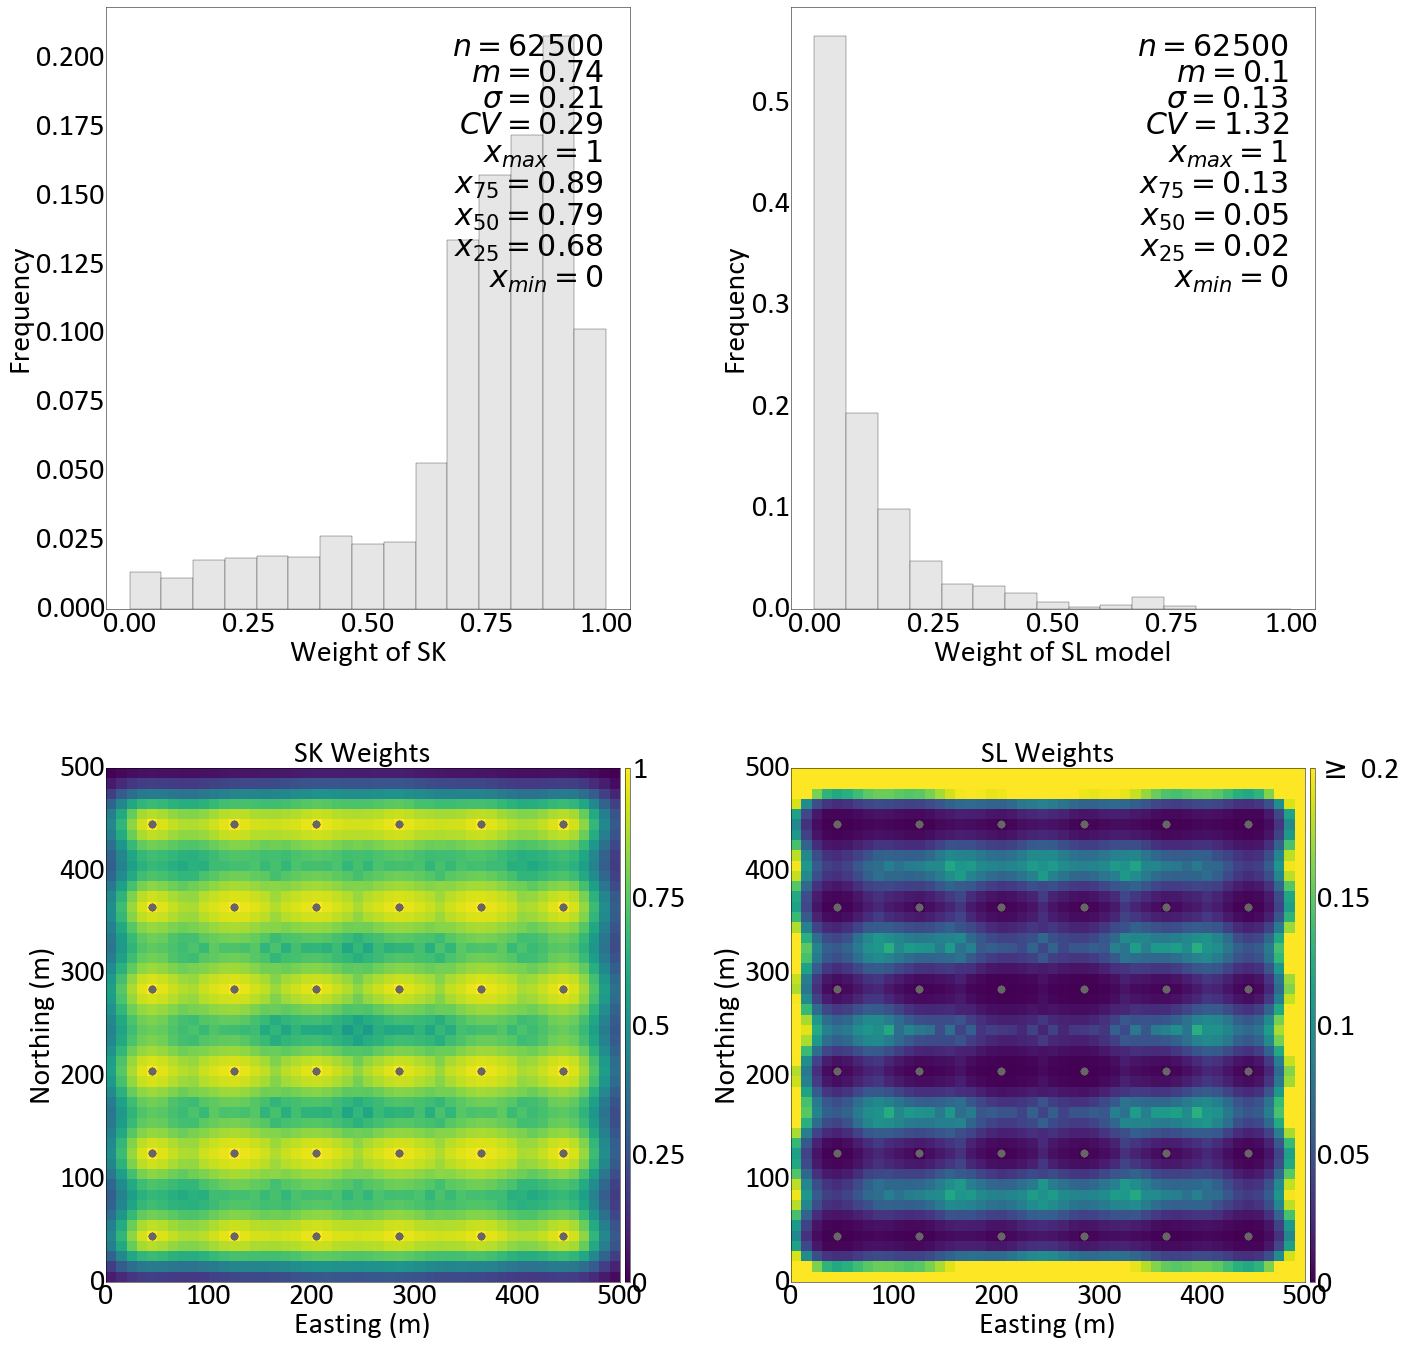

In [47]:
gs.set_style('pt30')

lim = (0,1)
lim2 = (0, 0.2)

gridsize = (2,2)

pltdat_WeightofSK = gs.DataFile('./predictions/WeightofSK.dat',griddef=griddef)
pltdat_WeightofML= gs.DataFile('./predictions/WeightofML.dat',griddef=griddef)


fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid(gridsize,(0,0)) 
ax2 = plt.subplot2grid(gridsize,(0,1))
ax3 = plt.subplot2grid(gridsize,(1,0)) 
ax4 = plt.subplot2grid(gridsize,(1,1))


gs.histplt(pltdat_WeightofSK ,ax=ax1, xlabel='Weight of SK')
gs.histplt(pltdat_WeightofML,ax=ax2, xlabel='Weight of SL model')

gs.pixelplt(pltdat_WeightofSK,griddef=griddef,vlim = lim, sliceno=20, ax=ax3,title = 'SK Weights')
gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=20,x='X', y='Y', z='Z', title = 'SK Weights')

gs.pixelplt(pltdat_WeightofML,griddef=griddef, vlim = lim2, sliceno=20, ax=ax4,title = 'SL Weights')
gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=20,x='X', y='Y', z='Z', title = 'SL Weights')

plt.savefig('./Figures/weight_hist_map.png', bbox_inches = 'tight', dpi = 150 )
plt.tight_layout()

### plotting b0 and b1

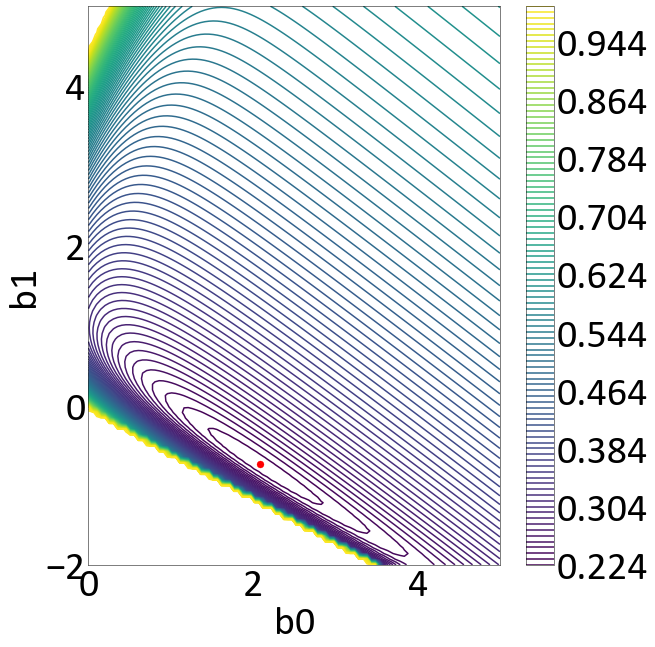

In [48]:
gs.set_style('pt40')

# plot the function f(x)
x = np.linspace(0, 5, 100)
y = np.linspace(-2, 5, 100)

X, Y = np.meshgrid(x, y)
Z = np.zeros((x.size, y.size))
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = objective((x[i], y[j]))
        if Z[i, j] >= 1:
            Z[i, j] = 1
        else:
            Z[i, j] = Z[i, j] 

fig= plt.figure(figsize=(10,10))

plt.contour(X, Y, Z.T, 100);
plt.colorbar()
plt.scatter(res.x[0], res.x[1], c='red',alpha=1)
plt.xlabel('b0')
plt.ylabel('b1')

plt.savefig('./Figures/weightsopt.png', bbox_inches = 'tight', dpi = 150)
plt.tight_layout()

# COMPARISION

In [49]:
gs.write_gslib(pd.DataFrame(superlearner_opt),'./predictions/superlearner_opt.dat')
gs.write_gslib(pd.DataFrame(superlearner_comb),'./predictions/superlearner_comb.dat')
gs.write_gslib(pd.DataFrame(yhat_all),'./predictions/superlearner.dat')

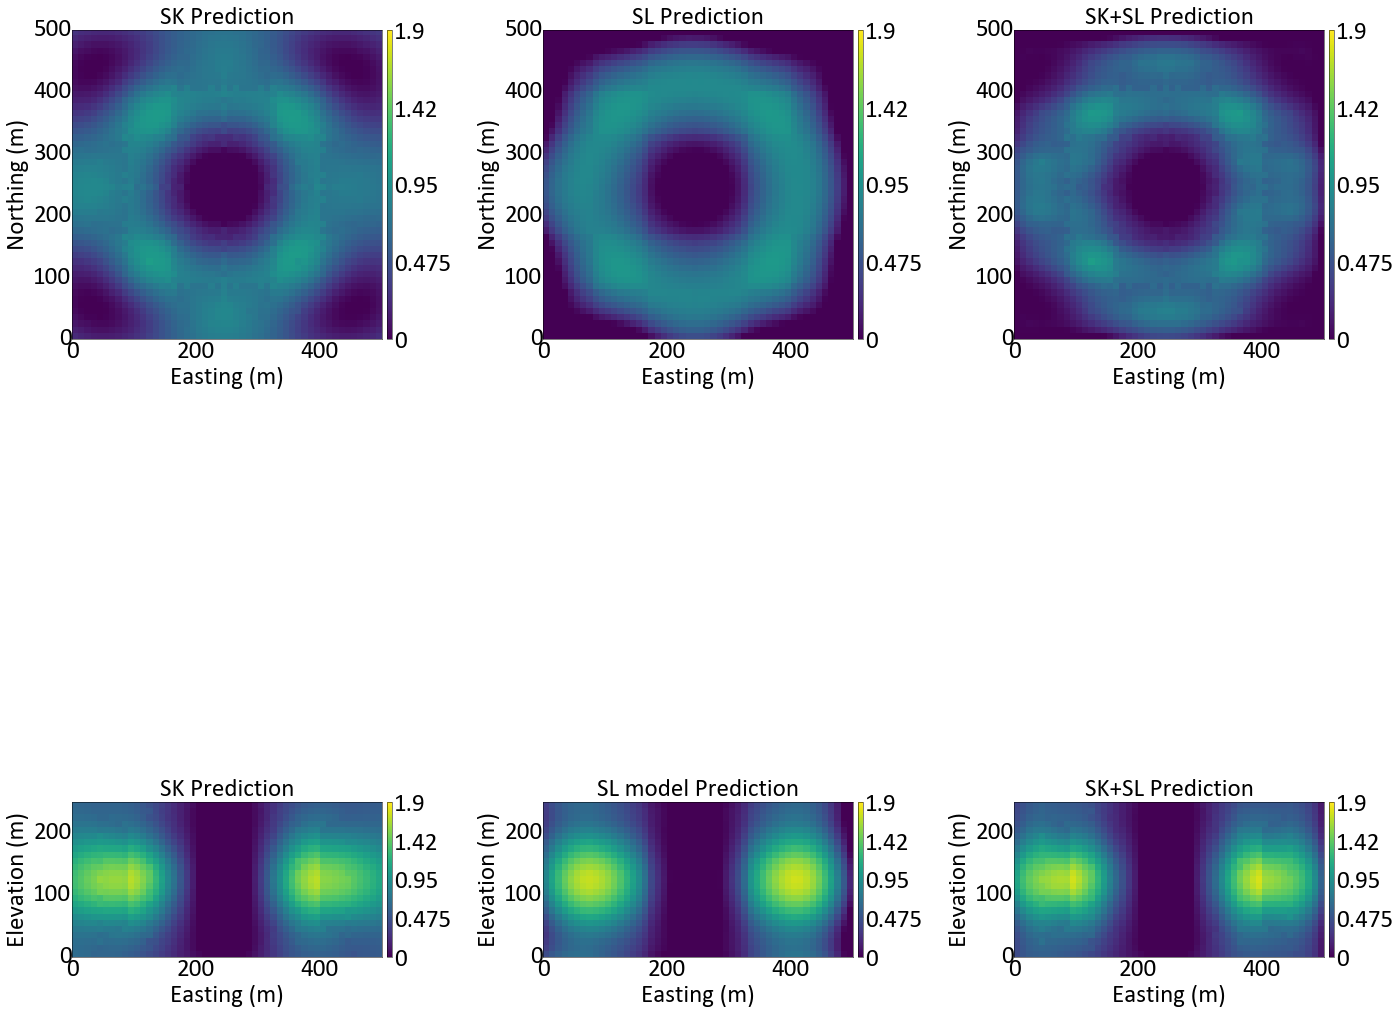

In [85]:
from scipy.ndimage import gaussian_filter

sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
gs.set_style('pt25')
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()
datatest = np.asmatrix(datasamplefl)
slinceno=20
slinceno2=20
vlim =(0,1.9)

var = 'value'
sigma = 0
gridsize = (2,2)


pltdat_kt3dn = gs.DataFile('./predictions/kt3dn.out',griddef=griddef)
pltdat_kt3dn.data['Estimate'][pltdat_kt3dn.data['Estimate'] < 0] = 0

pltdat_sl= gs.DataFile('./predictions/superlearner.dat',griddef=griddef)
pltdat_sl = (gaussian_filter((pltdat_sl.data['0']),sigma = sigma))
pltdat_sl[pltdat_sl < 0] = 0

pltdat_sl_comb= gs.DataFile('./predictions/superlearner_comb.dat',griddef=griddef)
pltdat_sl_comb = (gaussian_filter((pltdat_sl_comb.data['0']),sigma = sigma))
pltdat_sl_comb[pltdat_sl_comb < 0] = 0

pltdat_sl_opt = gs.DataFile('./predictions/superlearner_opt.dat',griddef=griddef)
pltdat_sl_opt = (gaussian_filter((pltdat_sl_opt.data['0']),sigma = sigma))
pltdat_sl_opt[pltdat_sl_opt < 0] = 0

gridsize2 = (2,3)

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid(gridsize2,(0,0)) 
ax2 = plt.subplot2grid(gridsize2,(0,1))
ax3 = plt.subplot2grid(gridsize2,(0,2))
# ax4 = plt.subplot2grid(gridsize2,(1,1))
ax4 = plt.subplot2grid(gridsize2,(1,0)) 
ax5 = plt.subplot2grid(gridsize2,(1,1))
ax6 = plt.subplot2grid(gridsize2,(1,2))
    
gs.pixelplt(pltdat_kt3dn,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax1,title = 'SK Prediction')
gs.pixelplt(pltdat_sl,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax2,title = 'SL Prediction')
# gs.pixelplt(pltdat_sl_comb,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax3,title = 'Non-opt SK+SL Prediction')
gs.pixelplt(pltdat_sl_opt,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax3,title = 'SK+SL Prediction')
gs.pixelplt(pltdat_kt3dn,orient = 'xz', griddef=griddef,vlim=vlim,sliceno=sliceno, ax=ax4,title = 'SK Prediction')
gs.pixelplt(pltdat_sl,orient = 'xz',griddef=griddef,vlim=vlim,sliceno=sliceno, ax=ax5,title = 'SL model Prediction')
# gs.pixelplt(pltdat_sl_comb,orient = 'xz',griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax3,title = 'SL+SK (without opt) Prediction')
gs.pixelplt(pltdat_sl_opt,orient = 'xz',griddef=griddef,vlim=vlim,sliceno=sliceno, ax=ax6,title = 'SK+SL Prediction')

plt.subplots_adjust (left = 0.1, bottom = 0.125, right = 1.6, top = 0.8, wspace = 0.2, hspace = 0.12)
plt.savefig('./Figures/Predictions.png',bbox_inches = 'tight', dpi = 150)
plt.tight_layout()

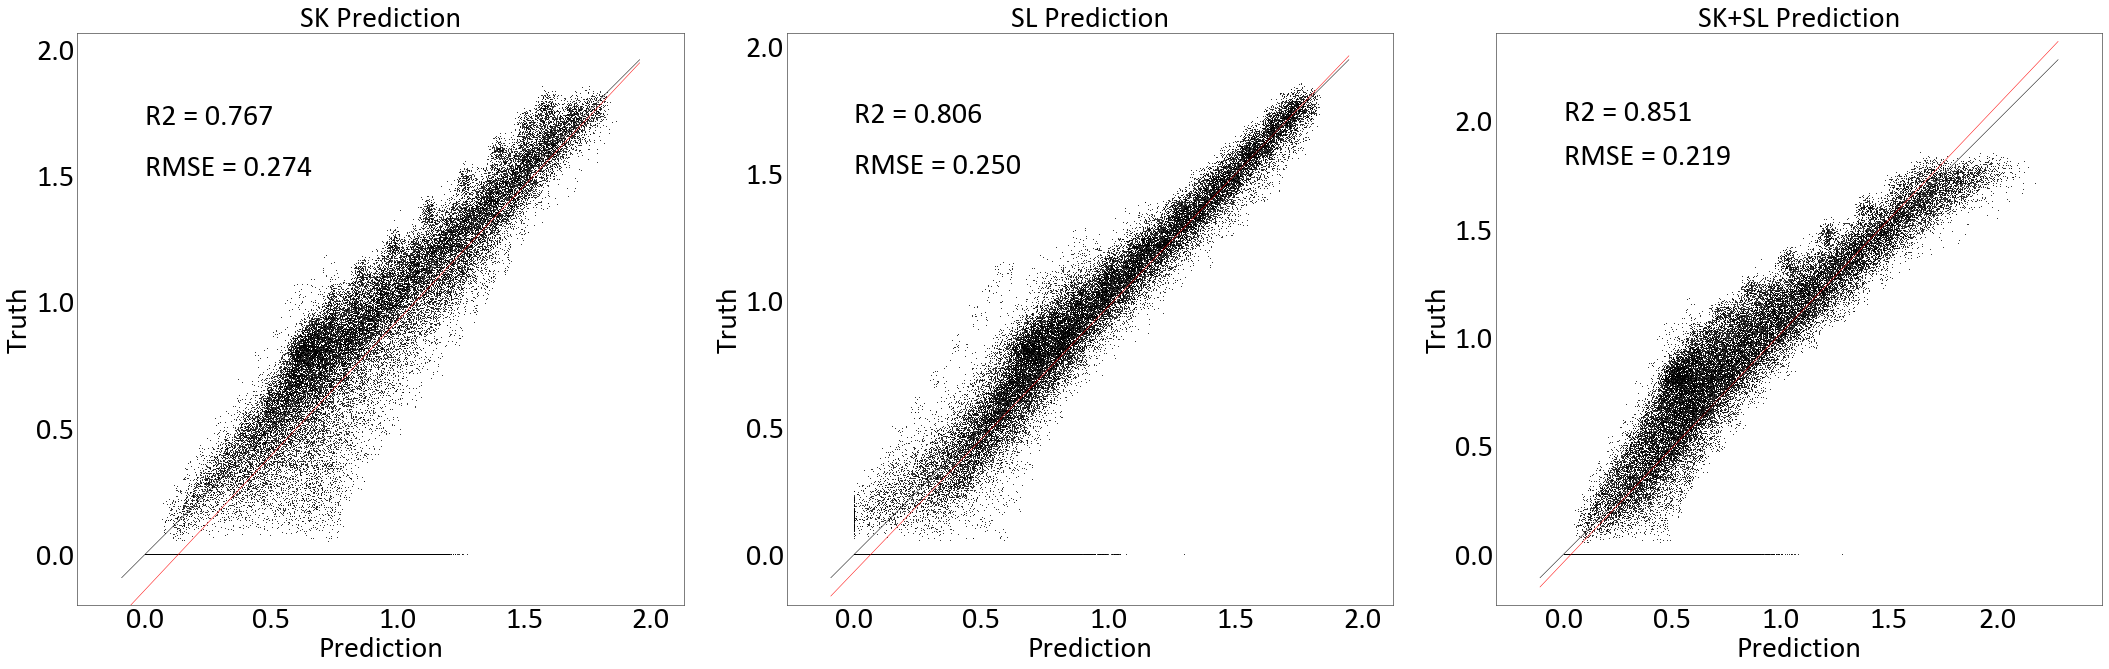

In [81]:
pltdat_kt3dn2 = gs.DataFile('./predictions/kt3dn.out',griddef=griddef)


pltdat_sl2= gs.DataFile('./predictions/superlearner.dat',griddef=griddef)
pltdat_sl2 = (gaussian_filter((pltdat_sl2.data['0']),sigma = sigma))


pltdat_sl_comb2= gs.DataFile('./predictions/superlearner_comb.dat',griddef=griddef)
pltdat_sl_comb2 = (gaussian_filter((pltdat_sl_comb2.data['0']),sigma = sigma))


pltdat_sl_opt2 = gs.DataFile('./predictions/superlearner_opt.dat',griddef=griddef)
pltdat_sl_opt2 = (gaussian_filter((pltdat_sl_opt2.data['0']),sigma = sigma))


gs.set_style('pt30')
stat_blk = []

f, axes = plt.subplots(1, 3, figsize=(30, 10))

ax1 = gs.scatxval(pltdat_kt3dn.data['Estimate'],sgsimfl.data['value'], ax=axes[0],xlabel='Prediction',title = 'SK Prediction',
            ylabel ='Truth', xlim = (0,4), ms =1 , stat_blk = stat_blk)

ax1.text(0,1.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn2.data['Estimate'])))
ax1.text(0,1.5,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(sgsimfl['value'],pltdat_kt3dn2.data['Estimate']))))


ax2 = gs.scatxval(pltdat_sl,sgsimfl['value'], ax=axes[1],xlabel='Prediction',title = 'SL Prediction',
            ylabel ='Truth', xlim = (0,4), ms = 1, stat_blk = stat_blk)
ax2.text(0,1.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_sl2)))
ax2.text(0,1.5,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(sgsimfl['value'],pltdat_sl2))))

# ax3 = gs.scatxval(pltdat_sl_comb,sgsimfl['value'], ax=axes[2],xlabel='Prediction',title = 'Non-opt SK+SL Prediction',
#             ylabel ='Truth', xlim = (0,4), ms=1, stat_blk = stat_blk)
# ax3.text(0,1.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_sl_comb2)),size=25)
# ax3.text(0,1.6,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(sgsimfl['value'],pltdat_sl_comb2)),size=25))

ax3 = gs.scatxval(pltdat_sl_opt, sgsimfl['value'],ax=axes[2],xlabel='Prediction',title = 'SK+SL Prediction',
            ylabel ='Truth', xlim = (0,4),ms=1, stat_blk = stat_blk)
ax3.text(0,2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_sl_opt2)))
ax3.text(0,1.8,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(sgsimfl['value'],pltdat_sl_opt2))))

plt.savefig('./Figures/Data-Reproduction.png',bbox_inches = 'tight', dpi = 150)

plt.tight_layout()

In [53]:
pltdat_sl

array([0.667659, 0.458451, 0.249955, ..., 0.501626, 0.738988, 0.9665  ])

In [54]:
def msre(predicted, actual):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return mean_error/ numpy.std(actual)

MSRE_SK = msre(np.asarray(pltdat_kt3dn2.data['Estimate']),np.asarray(sgsimfl.data['value']))
MSRE_SL = msre(pltdat_sl2,sgsimfl['value'])
MSRE_Combined= msre(pltdat_sl_comb2,sgsimfl['value'])
MSRE_Optimizedcombined = msre(pltdat_sl_opt2,sgsimfl['value'])

print('msre SK: %.3f' % MSRE_SK)
print('msre SL: %.3f' % MSRE_SL)
# print('msre SK+SL: %.3f' % MSRE_Combined)
print('msre SK+SL: %.3f' % MSRE_Optimizedcombined)

msre SK: 0.132
msre SL: 0.110
msre SK+SL: 0.084


In [55]:
from sklearn.metrics import make_scorer

# Calculate mean error
def mean_error( predicted, actual):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error)
	mean_error = sum_error / float(len(actual))
	return mean_error

meanerrorSK = mean_error(np.asarray(pltdat_kt3dn2.data['Estimate']),np.asarray(sgsimfl.data['value']))
meanerrorSL = mean_error(pltdat_sl2,sgsimfl['value'])
meanerrorCombined= mean_error(pltdat_sl_comb2,sgsimfl['value'])
meanerrorOptimizedcombined = mean_error(pltdat_sl_opt2,sgsimfl['value'])

print('mean error SK: %.3f' % meanerrorSK)
print('mean error SL: %.3f' % meanerrorSL)
# print('mean error SK+SL: %.3f' % meanerrorCombined)
print('mean error SK+SL: %.3f' % meanerrorOptimizedcombined)

mean error SK: 0.087
mean error SL: -0.015
mean error SK+SL: -0.012


### summary of statistics

In [56]:
print('mean SK: %.3f' % np.mean(pltdat_kt3dn.data['Estimate']))
print('mean SL: %.3f' % np.mean(pltdat_sl))
print('mean SK+SL: %.3f' % np.mean(pltdat_sl_opt))
print('mean Truth: %.3f' % np.mean(sgsimfl['value']))

mean SK: 0.699
mean SL: 0.645
mean SK+SL: 0.609
mean Truth: 0.604


In [57]:
print('SD SK: %.3f' % np.std(pltdat_kt3dn.data['Estimate']))
print('SD SL: %.3f' % np.std(pltdat_sl))
print('SD SK+SL: %.3f' % np.std(pltdat_sl_opt))
print('SD Truth: %.3f' % np.std(sgsimfl['value']))

SD SK: 0.477
SD SL: 0.517
SD SK+SL: 0.502
SD Truth: 0.567
